Alap import és adat beolvasás

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/raw/WineQT.csv")
df.head()
df.info()
df["quality"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


quality
5    483
6    462
7    143
4     33
8     16
3      6
Name: count, dtype: int64

Célváltozó és jellemzők

In [2]:
df = df.dropna()

# Bináris cél
df["target"] = (df["quality"] >= 7).astype(int)

X = df.drop(columns=["quality","target"])
y = df["target"]

X.shape, y.value_counts(normalize=True)

((1143, 12),
 target
 0    0.860892
 1    0.139108
 Name: proportion, dtype: float64)

autolog

In [3]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("wine-baseline")
mlflow.sklearn.autolog()

2025/11/04 20:50:22 INFO mlflow.tracking.fluent: Experiment with name 'wine-baseline' does not exist. Creating a new experiment.


Train/test split + baseline pipeline

2025/11/04 20:50:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '841f821d6c3c4394ad90d1f520e018f1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/04 20:50:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/gregorius/projects/ml-wine/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       197
           1       0.55      0.34      0.42        32

    accuracy                           0.87       229
   macro avg       0.72      0.65      0.67       229
weighted avg       0.85      0.87      0.86       229



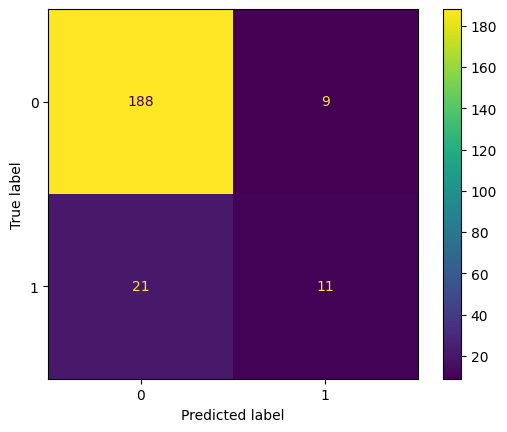

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

Alternatív modell

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = Pipeline(steps=[
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])

scores = cross_val_score(rf, X, y, cv=5, scoring="f1")
print("RF f1 (cv=5):", scores.mean(), "+/-", scores.std())

rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))

2025/11/04 20:50:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '07dc027325f2461a90713d50969e8604', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/04 20:50:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/gregorius/projects/ml-wine/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 

RF f1 (cv=5): 0.3510051018183403 +/- 0.21819972635392215


2025/11/04 20:50:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/gregorius/projects/ml-wine/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/11/04 20:50:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/gregorius/projects/ml-wi

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       197
           1       0.80      0.62      0.70        32

    accuracy                           0.93       229
   macro avg       0.87      0.80      0.83       229
weighted avg       0.92      0.93      0.92       229

